In [18]:
!pip install langchain langchain_core langchain_community langgraph langchain_groq pypdf pydantic

In [39]:
from langchain_groq import ChatGroq
from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import TypedDict
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from IPython.display import Image, display
from langchain_community.document_loaders import PyPDFLoader

In [ ]:


import os
from dotenv import load_dotenv
# LLM Setup
llm = ChatGroq(
    model="llama3-8b-8192",api_key=os.getenv("api_key")
)

In [ ]:

from typing import Literal
class Route(BaseModel):
    """The schema for our router's output."""
    step: Literal["shortlist", "reject", "escalate"] = Field(
        None, description="The routing decision for the candidate's application."
    )

In [ ]:

class State(TypedDict):
    """The state of our graph."""
    application: str  # The input resume text
    decision: str     # The routing decision from the router node
    response: str     # The final human-readable response

In [22]:
#Create a specialized LLM that will return structured output matching our Route schema
router_llm = llm.with_structured_output(Route)

In [ ]:


workflow = StateGraph(State)

In [24]:
from langchain_core.prompts import ChatPromptTemplate

In [ ]:

def screener_router_node(state: State):
    """
    This is the intelligent router. It analyzes the resume and makes a structured
    decision on the next step.
    """
    print("\n➡️ Analyzing resume and making a routing decision...")
    prompt = [
        SystemMessage(
            content=(
                '''You are a top-tier Senior Data Science Manager and an expert talent scout for a forward-thinking tech company in mid-2025. Your task is to perform an in-depth analysis of the provided resume for a **General Data Scientist** position. You must evaluate the candidate's skills, experience, and project impact to determine the next step in the hiring process.

        **PROFILE OF AN IDEAL CANDIDATE:**
        An ideal candidate demonstrates a blend of theoretical knowledge and practical application across several key areas:
        - **Core Technical Skills:** Proficient in Python (with libraries like Pandas, NumPy, Scikit-learn, Matplotlib/Seaborn) and strong SQL skills for data extraction and manipulation.
        - **Machine Learning Expertise:** Hands-on experience building and deploying various ML models (e.g., classification, regression, clustering). They should be able to discuss model evaluation, feature engineering, and the trade-offs of different algorithms.
        - **Project Impact:** Has worked on end-to-end projects and can articulate the business value or impact of their work, preferably with quantifiable metrics (e.g., improved model accuracy by X%, reduced operational costs, etc.).
        - **Modern Skills (Highly Desirable):** Experience with more advanced topics such as Deep Learning (TensorFlow/PyTorch), MLOps, cloud data platforms (AWS, GCP, Azure), or Generative AI (LLMs, RAG, LangChain) is a significant plus.

        **YOUR DECISION-MAKING FRAMEWORK:**
        Follow these rules in order to make your final decision. Your output must be a single, structured decision.

        1.  **'shortlist' Rule (Primary Filter):**
            You will decide **'shortlist'** if the candidate's resume clearly demonstrates **ALL** of the following:
            - Proficiency in Python and SQL.
            - Hands-on experience with core machine learning models (classification, regression, etc.).
            - At least one project where they describe the process from data gathering to model evaluation.

        2.  **'escalate' Rule (Interesting Edge Cases):**
            If the 'shortlist' criteria are NOT fully met, you will decide **'escalate'** for further review if the candidate fits one of these profiles:
            - **The Senior Specialist:** Has significant senior-level experience (e.g., 8+ years) in a related field like Software Engineering, Data Engineering, or traditional Business Intelligence, but lacks direct, modern ML project experience. They show strong foundational skills that could be transferable.
            - **The Gen AI Prodigy:** A more junior candidate who lacks broad project experience but demonstrates exceptional, cutting-edge skills in Generative AI or Deep Learning on personal or academic projects.

        3.  **'reject' Rule (Catch-All):**
            If the candidate does not meet any of the criteria for 'shortlist' or 'escalate', you will decide **'reject'**. This includes resumes that are focused only on basic data analysis/reporting (e.g., Excel, SQL queries without statistical modeling), show no evidence of programming or machine learning projects, or are otherwise not a fit for the role.'''
            )
        ),
        HumanMessage(content=state["application"]),
    ]
    # Invoke the specialized router LLM
    decision = router_llm.invoke(prompt)
    print(f"✅ Routing decision: '{decision.step}'")
    return {"decision": decision.step}


# These nodes are now simple workers; they just generate the final response text.
def schedule_hr_interview(state: State) -> State:
    return {"response": "Candidate has been shortlisted for an HR interview."}

def escalate_to_recruiter(state: State) -> State:
    return {"response": "Candidate has senior-level experience but doesn't match job skills. Escalate to recruiter."}

def reject_application(state: State) -> State:
    return {"response": "Candidate doesn't meet the job description and has been rejected."}


In [33]:
def route_decision(state: State):
    """A simple function to map the decision to the correct node."""
    return state["decision"]

In [34]:
workflow = StateGraph(State)

# Add the nodes
workflow.add_node("screener_router", screener_router_node)
workflow.add_node("shortlist", schedule_hr_interview)
workflow.add_node("escalate", escalate_to_recruiter)
workflow.add_node("reject", reject_application)

In [35]:
# Define the graph's flow
workflow.set_entry_point("screener_router")
workflow.add_conditional_edges(
    "screener_router",
    route_decision,
    # The dictionary maps the output of the 'route_decision' function
    # to the name of the next node to visit.
    {
        "shortlist": "shortlist",
        "escalate": "escalate",
        "reject": "reject",
    },
)

workflow.add_edge("shortlist", END)
workflow.add_edge("escalate", END)
workflow.add_edge("reject", END)


📊 Corrected Workflow Graph (using Structured Output Router):


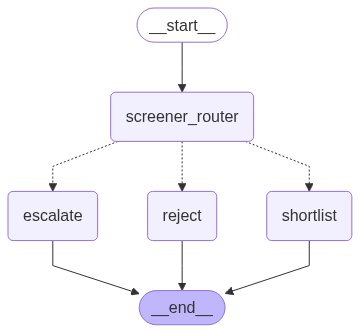

In [ ]:

app = workflow.compile()
print("\n Workflow Graph (using Structured Output Router):")
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:

#PDF PROCESSING & EXECUTION (WITH DETAILED REPORTING)

def run_screening_workflow(pdf_path: str):
    """
    Loads a PDF, runs the screening workflow, and prints a detailed report.
    """
    print(f"\n📄 Loading PDF from: {pdf_path}")
    try:
        loader = PyPDFLoader(pdf_path)
        resume_text = "\n".join([doc.page_content for doc in loader.load()])
        print("✅ PDF text extracted successfully.")
    except Exception as e:
        print(f"\n❌ ERROR: Failed to load or read the PDF file. Details: {e}")
        return

    print("\n🚀 Starting screening workflow...")
    # Invoke the workflow with the resume text
    result = app.invoke({"application": resume_text})

    # --- DETAILED REPORTING SECTION ---
    print("\n\n" + "="*35)
    print("      DETAILED SCREENING REPORT")
    print("="*35 + "\n")
    print(f"📄 File Processed:\n   {pdf_path}\n")
    print("🧠 Analysis & Decision:")
    # This shows the internal decision from the 'screener_router_node'
    print(f"   - Internal Routing Decision: '{result.get('decision', 'N/A')}'")
    # This shows the final human-readable outcome
    print(f"   - Final Outcome: {result.get('response', 'N/A')}\n")
    print("📝 Extracted Resume Snippet:")
    print("-" * 28)
    print(f"{result.get('application', 'No text extracted.')[:400]}...")
    print("-" * 28)



# RUN THE APPLICATION


try:
    # --- PASTE YOUR PDF FILE PATH HERE ---
    # For local files on Windows, it's good practice to use raw strings (r"...")
    # or forward slashes to avoid issues with backslashes.
    pdf_file_path = r"Resume(DS).pdf"

    run_screening_workflow(pdf_file_path)

except FileNotFoundError:
    print("\n\n⚠️ ERROR: File not found.")
    print("Please make sure the file path is correct and the file exists at that location.")
except Exception as e:
    print(f"\n\nAn unexpected error occurred: {e}")